In [1]:
#
# phase4 :
#   Logistic regression Bayesian learning
#
%matplotlib inline
import os
os.environ['THEANO_FLAGS'] = "mode=FAST_RUN,device=cpu,floatX=float32"
import theano
import theano.tensor as T
import config
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import network
import network.normFlow as nf
import utils
import utils.mathT as mathT
import utils.mathZ as mathZ
import utils.theanoGeneral as utilsT
import utils.optimizers as optimizers
import utils.plotZ as plotZ
import models
import models.moon as moon
import pandas as pd
import seaborn as sns  # statistical plots
floatX = utils.floatX

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
# parameter setup
DIMX = 2
DIMY = 3
DIMXY = DIMX * DIMY
DIMNF = DIMXY + DIMY
OUTPATH = '../report/figs/bayes/softmax'

Data generation, logistic
	input x  : (200, 2)
	1-of-K y  : (200, 3)
	weight.T : [[ 1.  1.]
 [-1. -1.]
 [ 2. -2.]]
	bias  b  : [ 1.  1.  3.]
Data saving path : None
keys : ['y', 'x', 'b', 'w', 'label']


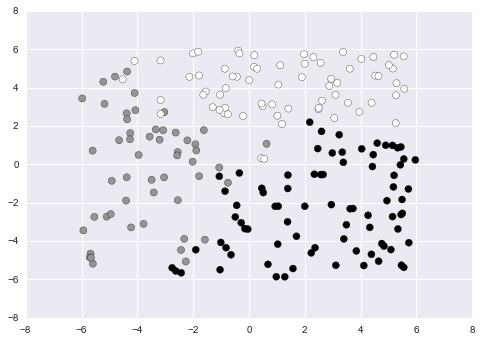

In [4]:
# data generation
SIZE = 200
xn = (npr.rand(SIZE,DIMX)-0.5)*12.

model = moon.Multiclass(DIMX,DIMY)
wn = np.asarray([[1,-1,2],[1,-1,-2]])   # DIMX, DIMY
bn = np.asarray([1, 1, 3])              # DIMY
                      
model.setTrueParamValues(w=wn,b=bn )
data = model.genData(fromx=xn, verbose=True)
fig = plotZ.category2d(data['x'],data['label'],dotarea=50)

In [15]:
# posterior

LOW, HIGH = -10,+10
GAP = (HIGH-LOW)/200.
gps, g1, g2 = mathZ.gridPoints((LOW,HIGH,GAP), (LOW,HIGH,GAP))

xname, yname = 'w11', 'w12'
idx1 = [0,0]
idx2 = [0,1]
L = gps.shape[0]
wns = np.repeat(wn.reshape((1,DIMX,DIMY)),L,axis=0)
bns = np.repeat(bn.reshape((1,DIMY)), L, axis=0)
wns[:, idx1[0], idx1[1] ] = gps[:,0]
wns[:, idx2[0], idx2[1] ] = gps[:,1]

logs_, logall_ = model.nlogPy_xw(data['x'],data['y'],wns,bns)



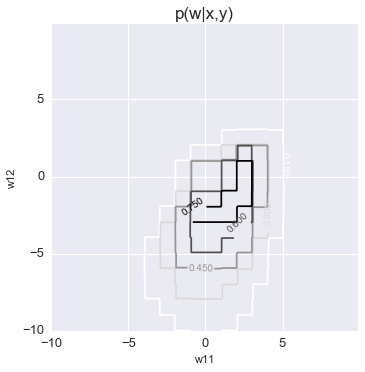

In [18]:
PRIOR_WEIGHT = 0
logs = logs_ + model.nlogPw(wns)*PRIOR_WEIGHT
logs = logs/SIZE
pws = logs.reshape(g1.shape[1],g2.shape[0]) 
pws = np.exp(pws)
fig = plt.figure()
CS = plt.contour(g1,g2,pws)
plt.clabel(CS, inline=1, fontsize=10)
plt.axes().set_aspect('equal')
plt.xlabel(xname); plt.ylabel(yname)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.title('p(w|x,y)', fontsize=17)
plt.show()

In [5]:
# parameter setup
SAMPLINGNUM = 30
NUM_LAYERS = 8
Z0_TYPE = 'uniform'
STD = 16

In [6]:
# construction variational model
iaf = nf.NormFlowModel( dim=DIMNF, numlayers=NUM_LAYERS,noisestd=1.)  
e = iaf.getNoiseVar(SAMPLINGNUM)
z, logqz = iaf.reparam(e)  # z = L * ( dimx * dimy + dimy )

# matching latent variables to parameters
wt = z[:,:DIMXY].reshape((SAMPLINGNUM,DIMX,DIMY))
bt = z[:,DIMXY:]

print wt.shape.eval()
print bt.shape.eval()
print logqz.shape.eval()

[30  2  3]
[30  3]
[30]


In [7]:
# setting cost variable
#x = T.fmatrix()
#y = T.fmatrix()
reload(models.moon)
x = utils.theanoGeneral.sharedf(data['x'])
y = utils.theanoGeneral.sharedf(data['y'])

logpy_xw, temp = model.logPy_xw(x,y,wt,bt)
logpw = model.logPw(wt,bt)

In [8]:
# ELBO
cost = T.mean( logqz - (logpy_xw + logpw) )  # negative-ELBO

params = iaf.getParams()
grads = [ T.grad(cost,p,consider_constant=[e]) for p in params ]

In [9]:
# optimisation setup
iaf.reInit()
opt = optimizers.SGD(params,lr=0.05,momentum=0.5,decay=0.001)
updates = opt.getUpdates(params,grads)

outputs = [ cost, T.mean(logpy_xw), T.mean(logqz) ]
estep = theano.function(inputs=[],outputs=outputs,updates=updates)

In [10]:
# for presentation
e2 = iaf.getNoiseVar(50000)
z2, logqz2 = iaf.reparam(e2)
fez2 = theano.function(inputs=[],outputs=[e2,z2])

In [11]:
# training
NUMITER = 1000
keys = ['cost','pxz','qz']
record = {}

# mb.setStd(0.7)
for k in keys:
    record[k] = []
for i in range(NUMITER):
    # running updates
    # bnn
#     out = estep(valx)    
    # apple
    out = estep()
    for i,q in enumerate(out):
        record[keys[i]].append( q )        
for k in keys:
    record[k] = np.asarray( record[k] )

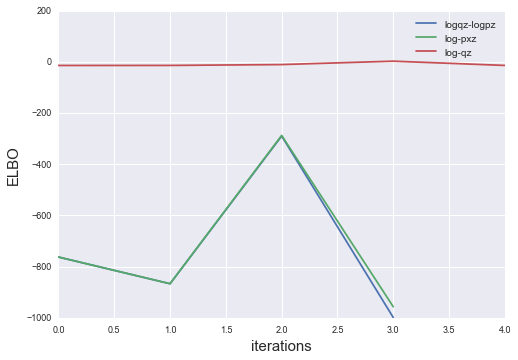

In [12]:
# plt.plot( range(NUMITER), record['cost'],'-' )
# plt.show()
xs = range(NUMITER)
plt.plot( xs, -record['cost'], '-', label='logqz-logpz')
plt.xlabel('iterations',fontsize=15)
plt.ylabel('ELBO',fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=9)
plt.savefig(OUTPATH+'/elbo_L%d.png'%(NUM_LAYERS))

plt.plot( xs, record['pxz'], '-', label='log-pxz')
plt.plot( xs, record['qz'], '-', label='log-qz')

plt.legend()
plt.show()

In [13]:
# estimated posterior
xlims = (-4,+4)
ylims = (-4,+4)
es, zs = fez2()
AXES = (0,1)
heatmap, xedges, yedges = np.histogram2d( zs[:,AXES[0]], zs[:,AXES[1]], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.xlim(xlims)
plt.ylim(ylims)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.title('q(z), num-layer %d' % (NUM_LAYERS), fontsize=17)
plt.savefig( OUTPATH+'/dist_L%d_iter%d.png'%(NUM_LAYERS,NUMITER))

ValueError: cannot convert float NaN to integer

(50000, 9)
[ nan  nan  nan  nan  nan  nan  nan  nan  nan]
